# Inspect postproces for pe_present_on_image -> pe_exam

tested by exp010, fold0 validation

In [2]:

%cd ~/kaggle/rsna-str/workdir

/home/haito/kaggle/rsna-str/workdir


In [3]:


import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

from src.factory import *
from src.utils import *

In [4]:
DATADIR = Path("../input/rsna-str-pulmonary-embolism-detection/")

train = pd.read_csv(DATADIR / "train.csv")
pre = pd.read_csv(DATADIR / "split.csv")
train = train.merge(pre, on="StudyInstanceUID")

In [5]:
t = train[train.fold == 0]

In [6]:
studies = t.StudyInstanceUID.unique()


In [7]:
agg = t.groupby("StudyInstanceUID")["SOPInstanceUID"].apply(list)
agg_one = t.groupby("StudyInstanceUID").first()

In [8]:
def post1(p_arr, q=90):
    return np.percentile(p_arr, q=q)

In [9]:
from sklearn.metrics import log_loss

In [90]:
### exp 010
p = "output/010_pe_pos/out.valid.fold0"  # ep0
# p = "output/010_pe_pos/out.valid.fold0_ep1"

res = load_pickle(p)

raw_pred = pd.DataFrame({
    "sop": res["ids"],
    "pe_present_on_image": res["outputs"]["pe_present_on_image"],
    "rightsided_pe": res["outputs"]["rightsided_pe"],
    "leftsided_pe": res["outputs"]["leftsided_pe"],
    "central_pe": res["outputs"]["central_pe"],
})
raw_pred = raw_pred.set_index("sop")

### 
def get_pred(_path):
    res = load_pickle(_path)
    raw_pred = pd.DataFrame({
        "sop": res["ids"],
        "pe_present": res["outputs"]["pe_present_on_image"]  # 010 or later
    })
    return raw_pred.set_index("sop")

raw_pred_010ep0 = get_pred("output/010_pe_pos/out.valid.fold0")
raw_pred_010ep1 = get_pred("output/010_pe_pos/out.valid.fold0_ep1")
raw_pred_031tune_ep2 = get_pred("output/031_pe_present___oversample___tune/valid.fold0-ep2.pickle")
raw_pred_035ep1 = get_pred("output/035_pe_present___448/valid.fold0-ep1.picle")

In [91]:
# 001
_path = "output/001_base/fold0_valid.pickle"
res = load_pickle(_path)
raw_pred = pd.DataFrame({
    "sop": res["ids"],
    "pe_present": res["outputs"]
})
raw_pred = raw_pred.set_index("sop")

In [ ]:
""" exp 001 model (ep1)
q=90.00 logloss:0.4335881782152035
q=91.00 logloss:0.4261582133852183
q=92.00 logloss:0.41820680933855464
q=93.00 logloss:0.40965706920377787
q=94.00 logloss:0.40250102547323763
q=95.00 logloss:0.399617003382453   <=== たまたま Best
q=96.00 logloss:0.4014378415196566
q=97.00 logloss:0.40659142078878496
q=98.00 logloss:0.4293089602081556
q=99.00 logloss:0.4881203309768597
"""

In [ ]:
""" exp 010 model (ep0)
q=90 logloss:0.580963053992852
q=91 logloss:0.5561516892147172
q=92 logloss:0.5302883445027334
q=93 logloss:0.5057102176781858
q=94 logloss:0.48133613115138896
q=95 logloss:0.4547570238934727   <=========== Bad
q=96 logloss:0.4293633715604374
q=97 logloss:0.40440298977917516
q=98 logloss:0.383646086091538
q=98.80 logloss:0.37546814335089845
q=98.90 logloss:0.3744332339894111   <=========== Mininum for fold0
q=99.00 logloss:0.3745150839621268
q=99 logloss:0.374515083962127
q=99.10 logloss:0.3755236864711825
q=99.20 logloss:0.3776048971290255
q=99.5 logloss:0.389937762524077
q=99.7 logloss:0.40671684673171016
q=99.9 logloss:0.43696034136869655
q=99.95 logloss:0.44722869414163663
q=99.99 logloss:0.4569151069554547
"""

In [ ]:
""" exp 010 model (ep1)
q=90.00 logloss:0.5279595949554328
q=91.00 logloss:0.5052608242921037
q=92.00 logloss:0.4834110695747726
q=93.00 logloss:0.46385352130528656
q=94.00 logloss:0.4473139354706962
q=95.00 logloss:0.43102377556895444
q=96.00 logloss:0.41591824329556415
q=97.00 logloss:0.40408809195191403   <================ Best. epが進むほど最適なpercentilがさがる. epが進むとOver-confになるからだと思われる. exp001,best 0.3996
q=98.00 logloss:0.4081253578858078
q=99.00 logloss:0.4430865048629079
"""

In [80]:
F = 3.8250639579850194  # for exp001ep1
def calib_p(arr, factor=F):  # set factor>1 to enhance positive prob
    return arr * factor / (arr * factor + (1-arr))

In [ ]:
"""
calib後の po_exam推定

calibなし, best
q=95.00 logloss:0.399617003382453


q=60.00 logloss:0.698643776447078
q=63.00 logloss:0.6365354999541909
q=66.00 logloss:0.5879396129561644
q=69.00 logloss:0.5459351137856083
q=72.00 logloss:0.51321447134653
q=75.00 logloss:0.4869159619202598
q=78.00 logloss:0.46734739184806373
q=81.00 logloss:0.45602309782309475
q=84.00 logloss:0.4533383621932218   <=== Bad
q=87.00 logloss:0.46169121075914676
q=90.00 logloss:0.4797557469032024
q=93.00 logloss:0.5235644453652069
q=96.00 logloss:0.6101237719455836
q=99.00 logloss:0.8752916874879507

そもそもN-percentileがよくなさそうではある
"""

In [68]:
# ナイーブな後処理
# いくつかパターンためしたがどれもだめ
def post2_prob_pos(p_pe_arr, q=1.0):
    p_pe_arr = np.sort(p_pe_arr.values)[int(len(p_pe_arr)*0.7):]
    length = len(p_pe_arr)
    """q : [0,1] """
    neg_prob = 1.0
    for p in p_pe_arr:
        neg_prob *= np.power((1-p), 60 / length)
    return 1 - neg_prob

mean 0.28603941213300405


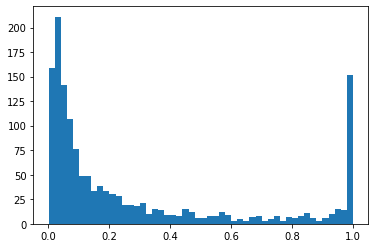

factor=0.050 logloss:0.4258650505514252


In [70]:
# for factor in [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 1.0]:
# for factor in [0.05]:
for _ in [0.05]:

    LABELS = []
    PREDS = []

    for study in t.StudyInstanceUID.unique():
        sops = agg.loc[study]
        label = agg_one.loc[study]
        label_is_pe = int((not label.indeterminate) and (not label.negative_exam_for_pe))
        LABELS.append(label_is_pe)

        prediction =  raw_pred.loc[sops]  # preds for current study

        # pe pre
        probs_pe_present = prediction.pe_present
        probs_pe_present = calib_p(probs_pe_present)
        pe_prob = post2_prob_pos(probs_pe_present, q=0.2)


        pe_prob = calib_p(pe_prob, factor=0.02)

        PREDS.append(pe_prob)

        # break
    # break
    print( "mean", np.mean(PREDS) )

    plt.hist(PREDS, bins=50)
    plt.show()
    print(f"factor={factor:.3f} logloss:{log_loss(LABELS, PREDS)}")
    break


In [ ]:
for q in np.arange(0.00, 0.1, 0.01):
    LABELS = []
    PREDS = []

    for study in t.StudyInstanceUID.unique():
        sops = agg.loc[study]
        label = agg_one.loc[study]
        label_is_pe = int((not label.indeterminate) and (not label.negative_exam_for_pe))
        LABELS.append(label_is_pe)

        prediction =  raw_pred.loc[sops]  # preds for current study

        # pe pre
        probs_pe_present = prediction.pe_present
        probs_pe_present = calib_p(probs_pe_present)
        pe_prob = post2_prob_pos(probs_pe_present, q=q)

        print( "mean", np.mean(pe_prob) )

        pe_prob = calib_p(pe_prob)

        PREDS.append(pe_prob)

        # break
    # break

    print(f"q={q:.3f} logloss:{log_loss(LABELS, PREDS)}")


In [ ]:
""" 
calib + percentile のみのくみあわせ === 
    比較対象 q=95.00 logloss:0.3996
""" 

In [97]:
best = np.inf
best_set = None

# for calib_f in [1/32, 1/16, 1/10, 1/8, 1/6, 1/4, 1/2, 0.75, 1, 1.5, 2, 4]:
#     for percentile in [60, 70, 80, 85 ,90, 93, 95, 97, 97.5, 98, 98.5,98.7, 99, 99.3, 99.5, 99.7, 99.9, 100]:
# ===> final best: 0.37856055369366365 (0.25, 99)

for percentile in [95, 98.0, 99, 99.5, 100]:
    best_loss = np.inf
    best_set = None
    for calib_f in [1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64]:

        LABELS = []
        PREDS = []

        for study in t.StudyInstanceUID.unique():
            sops = agg.loc[study]
            label = agg_one.loc[study]
            label_is_pe = int((not label.indeterminate) and (not label.negative_exam_for_pe))
            LABELS.append(label_is_pe)

            prediction =  raw_pred.loc[sops]  # preds for current study

            # pe pre
            probs_pe_present = prediction.pe_present
            probs_pe_present = calib_p(probs_pe_present, factor=calib_f)
            pe_prob = np.percentile(probs_pe_present, q=percentile)

            PREDS.append(pe_prob)
        loss_val = log_loss(LABELS, PREDS)

        if loss_val < best_loss:
            best_loss = loss_val
            best_set = (calib_f, percentile)
    print(f"best, per percnetile:{percentile} calib:{best_set[0]} best_loss {best_loss}")


best, per percnetile:95 calib:1 best_loss 0.399617003382453
best, per percnetile:98.0 calib:0.5 best_loss 0.3804158758247496
best, per percnetile:99 calib:0.25 best_loss 0.37856055369366365
best, per percnetile:99.5 calib:0.25 best_loss 0.38425875684913247
best, per percnetile:100 calib:0.125 best_loss 0.3985051085546535


In [100]:
best = np.inf
best_set = None


LABELS = []
PREDS = []

for study in t.StudyInstanceUID.unique():
    sops = agg.loc[study]
    label = agg_one.loc[study]
    label_is_pe = int((not label.indeterminate) and (not label.negative_exam_for_pe))
    LABELS.append(label_is_pe)

    prediction =  raw_pred.loc[sops]  # preds for current study

    # pe pre
    probs_pe_present = prediction.pe_present

    pe_prob1 = np.percentile(calib_p(probs_pe_present, factor=1/2), q=98)
    pe_prob2 = np.percentile(calib_p(probs_pe_present, factor=1/4), q=99)
    pe_prob3 = np.percentile(calib_p(probs_pe_present, factor=1/4), q=99.5)

    pe_prob = (pe_prob1 + 2 * pe_prob2 + pe_prob3) / 4.0

    PREDS.append(pe_prob)
loss_val = log_loss(LABELS, PREDS)

print(f"combined: loss {loss_val}")


combined: loss 0.3768648810456305


In [ ]:
"""
Linear Regression する. 結果は悪い. 真ん中 q=99 の重みが一番小さい
featureをq=99のみにしてさえ悪い?

weight合計を1にしないといけなさそう
"""

In [131]:
Y = []
X = []

def prob_to_logit(prob):
    return np.log(prob/(1-prob))
# Q_ARR = [96, 99, 99.5]
Q_ARR = [99]

studies_all = t.StudyInstanceUID.unique()
studies  = studies_all[: len(studies_all) // 2]

# studies2 = studies_all[len(studies_all) // 2:]
studies2 = studies_all

for study in studies:
    sops = agg.loc[study]
    label = agg_one.loc[study]
    label_is_pe = int((not label.indeterminate) and (not label.negative_exam_for_pe))
    Y.append(label_is_pe)

    probs_pe_present = raw_pred.loc[sops].pe_present
    X.append([prob_to_logit(np.percentile(probs_pe_present, q=q)) for q in Q_ARR])

X, Y = np.array(X), np.array(Y)


from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X, Y)
print(clf.coef_, clf.intercept_)

if False:  # 手動設定. これをすると、fold0全体に対してのlossが手動の結果とほぼ一致
    clf.coef_ = np.array([[1]])
    clf.intercept_ = np.array([ np.log(1/4) ])

LABELS = []
PREDS = []
for study in studies2:
    sops = agg.loc[study]
    label = agg_one.loc[study]
    label_is_pe = int((not label.indeterminate) and (not label.negative_exam_for_pe))
    LABELS.append(label_is_pe)

    prediction =  raw_pred.loc[sops]  # preds for current study

    # pe pre
    probs_pe_present = prediction.pe_present
    pe_prob = clf.predict_proba([[prob_to_logit(np.percentile(probs_pe_present, q=q)) for q in Q_ARR]])[0]

    PREDS.append(pe_prob)
loss_val = log_loss(LABELS, PREDS)
print(f"loss {loss_val}")

[[1.04035578]] [-1.36747889]
loss 0.3784378614644151


In [109]:
clf.coef_

array([[0.54636552, 0.14539564, 0.32995032]])

In [ ]:
""" weight 最適化 """

In [ ]:
"""
Q_ARR = [98, 99, 99.5]に相当するものを 手動でやったとき
combined: loss 0.3768648810456305

以下でやった時
0.376077
x: array([ 0.47733139,  0.08806671,  0.29714744, -1.16465475])

しかし、そもそもが誤差
"""

In [150]:
def prob_to_logit(prob):
    return np.log(prob/(1-prob))
def logit_to_prob(logit):
    return 1 / (1 + np.exp(- logit))
1.3 == prob_to_logit(logit_to_prob(1.3))

# Q_ARR = [96, 99, 99.5]
Q_ARR = [98, 99, 99.5]
Q_LEN = len(Q_ARR)
# Q_ARR = [99]

studies_all = t.StudyInstanceUID.unique()

LABELS = []
FEATS_ARR = []
for study in studies_all:
    sops = agg.loc[study]
    label = agg_one.loc[study]
    label_is_pe = int((not label.indeterminate) and (not label.negative_exam_for_pe))
    LABELS.append(label_is_pe)

    probs_pe_present = raw_pred.loc[sops].pe_present
    feats = [prob_to_logit(np.percentile(probs_pe_present, q=q)) for q in Q_ARR]
    FEATS_ARR.append(feats)

def get_score(weight):
    # print("called")
    PREDS = [] 
    for i in range(len(studies_all)):
        feats = FEATS_ARR[i]
        logit = ( np.sum(feats * weight[:Q_LEN]) / np.sum(weight[:Q_LEN]) ) + weight[Q_LEN]
        PREDS.append( logit_to_prob(logit) )
    return log_loss(LABELS, PREDS)

weights = np.array([1/Q_LEN] * Q_LEN + [np.log(1/4)])
from scipy.optimize import minimize
minimize(get_score, weights,
                       args=(),
                       method="Nelder-Mead",
                       tol=1e-6,
                       # options={"maxiter": 10}
                       )

 final_simplex: (array([[ 0.53036821,  0.0978519 ,  0.33016382, -1.16465475],
       [ 0.5303684 ,  0.09785134,  0.33016424, -1.16465485],
       [ 0.53036847,  0.09785094,  0.33016406, -1.16465466],
       [ 0.53036894,  0.09785147,  0.33016375, -1.1646544 ],
       [ 0.53036828,  0.0978516 ,  0.33016405, -1.16465472]]), array([0.37607725, 0.37607725, 0.37607725, 0.37607725, 0.37607725]))
           fun: 0.3760772490070748
       message: 'Optimization terminated successfully.'
          nfev: 227
           nit: 130
        status: 0
       success: True
             x: array([ 0.53036821,  0.0978519 ,  0.33016382, -1.16465475])

In [ ]:
"""
Right left central
"""

In [27]:
# POST1

MEANS_IND = 0.020484822355039723

#for q in [97,97.5,98, 98.5,99,99.5]:
#for q in np.arange(98.5, 99.3, 0.1):
for q in np.arange(60.0, 99.9, 3):
# for q in [98, 98.9]:

    LABELS = []
    PREDS = []

    for study in t.StudyInstanceUID.unique():
        sops = agg.loc[study]
        label = agg_one.loc[study]
        label_is_pe = int((not label.indeterminate) and (not label.negative_exam_for_pe))
        LABELS.append(label_is_pe)

        prediction =  raw_pred.loc[sops]  # preds for current study

        # pe pre
        probs_pe_present = prediction.pe_present
        probs_pe_present = calib_p(probs_pe_present)
        pe_prob = post1(probs_pe_present, q=q)
        PREDS.append(pe_prob)

    print(f"q={q:.2f} logloss:{log_loss(LABELS, PREDS)}")


q=60.00 logloss:0.698643776447078
q=63.00 logloss:0.6365354999541909
q=66.00 logloss:0.5879396129561644
q=69.00 logloss:0.5459351137856083
q=72.00 logloss:0.51321447134653
q=75.00 logloss:0.4869159619202598
q=78.00 logloss:0.46734739184806373
q=81.00 logloss:0.45602309782309475
q=84.00 logloss:0.4533383621932218
q=87.00 logloss:0.46169121075914676
q=90.00 logloss:0.4797557469032024
q=93.00 logloss:0.5235644453652069
q=96.00 logloss:0.6101237719455836


KeyboardInterrupt: 

In [59]:
MEANS_IND = 0.020484822355039723

#for q in [97,97.5,98, 98.5,99,99.5]:
#for q in np.arange(98.5, 99.3, 0.1):
#for q in np.arange(90.0, 99.9, 1):
for q in [98, 98.9]:

    LABELS = []
    PREDS = []
    LABELS_RIGHT = []
    PREDS_RIGHT = []
    PREDS_RIGHT2 = []
    LABELS_LEFT= []
    PREDS_LEFT = []
    PREDS_LEFT2 = []
    LABELS_CENT = []
    PREDS_CENT = []
    PREDS_CENT2 = []

    for study in t.StudyInstanceUID.unique():
        sops = agg.loc[study]
        label = agg_one.loc[study]
        label_is_pe = int((not label.indeterminate) and (not label.negative_exam_for_pe))
        LABELS.append(label_is_pe)

        LABELS_RIGHT.append(label.rightsided_pe)
        LABELS_LEFT.append(label.leftsided_pe)
        LABELS_CENT.append(label.central_pe)

        prediction =  raw_pred.loc[sops]  # preds for current study
        # pe pre
        probs_pe_present = prediction.pe_present_on_image
        pe_prob = post1(probs_pe_present, q=q)
        PREDS.append(pe_prob)

        ### rightsided
        ave_right = np.clip( np.sum( prediction.rightsided_pe ) / np.sum( prediction.pe_present_on_image ), 0, 1)
        ave_left  = np.clip( np.sum( prediction.leftsided_pe )  / np.sum( prediction.pe_present_on_image ), 0, 1)
        ave_cent  = np.clip( np.sum( prediction.central_pe )    / np.sum( prediction.pe_present_on_image ), 0, 1)

        if 0:
            PREDS_RIGHT.append( (1-MEANS_IND) * pe_prob *  ave_right)
            PREDS_LEFT.append ( (1-MEANS_IND) * pe_prob *  ave_left)
            PREDS_CENT.append ( (1-MEANS_IND) * pe_prob *  ave_cent)
        elif 0:
            PREDS_RIGHT.append( pe_prob *  ave_right)
            PREDS_LEFT.append ( pe_prob *  ave_left)
            PREDS_CENT.append ( pe_prob *  ave_cent)
        elif 0:
            PREDS_RIGHT.append( (1-MEANS_IND) * np.percentile( prediction.rightsided_pe, 99 ) )
            PREDS_LEFT .append( (1-MEANS_IND) * np.percentile( prediction.leftsided_pe, 99 ) )
            PREDS_CENT .append( (1-MEANS_IND) * np.percentile( prediction.central_pe, 99 ) )
        elif 1:
            PREDS_RIGHT.append( np.percentile( prediction.rightsided_pe, 99 ) * 1.15 )
            PREDS_LEFT .append( np.percentile( prediction.leftsided_pe, 99 )  * 1.15 )
            PREDS_CENT .append( np.percentile( prediction.central_pe, 99 )    * 1.15 )

        PREDS_RIGHT2.append( pe_prob * 0.849707702540123 + (1-pe_prob) * 0 )
        PREDS_LEFT2.append ( pe_prob * 0.6957545475146886 + (1-pe_prob) * 0 )
        PREDS_CENT2.append ( pe_prob * 0.1796915446534345 + (1-pe_prob) * 0 )

        # print(study, label_is_pe, pe_prob)

    print(f"q={q:.2f} logloss:{log_loss(LABELS, PREDS)}")

    print("RIGHT")
    print(f"    now  logloss:{log_loss(LABELS_RIGHT, PREDS_RIGHT)}")
    print(f"    past logloss:{log_loss(LABELS_RIGHT, PREDS_RIGHT2)}")
    print(f"    base logloss:{log_loss(LABELS_RIGHT, len(LABELS_RIGHT)*[np.mean(LABELS_RIGHT)] )}")

    print("LEFT")
    print(f"   logloss:{log_loss(LABELS_LEFT, PREDS_LEFT)}")
    print(f"   logloss:{log_loss(LABELS_LEFT, PREDS_LEFT2)}")
    print(f"   logloss:{log_loss(LABELS_LEFT, len(LABELS_LEFT)*[np.mean(LABELS_LEFT)] )}")

    print("CENTRAL")
    print(f"   logloss:{log_loss(LABELS_CENT, PREDS_CENT)}")
    print(f"   logloss:{log_loss(LABELS_CENT, PREDS_CENT2)}")
    print(f"   logloss:{log_loss(LABELS_CENT, len(LABELS_CENT)*[np.mean(LABELS_CENT)] )}")


q=98.00 logloss:0.383646086091538
RIGHT
    now  logloss:0.3451702421090064
    past logloss:0.3617282748788149
    base logloss:0.5762224411886869
RIGHT
   logloss:0.3214743942633246
   logloss:0.3394795618701709
   logloss:0.5300883358743675
CENTRAL
   logloss:0.1386441131671042
   logloss:0.15336295710202394
   logloss:0.23192769500092492
q=98.90 logloss:0.374433233989411
RIGHT
    now  logloss:0.3451702421090064
    past logloss:0.35746662291195486
    base logloss:0.5762224411886869
RIGHT
   logloss:0.3214743942633246
   logloss:0.3401054436957059
   logloss:0.5300883358743675
CENTRAL
   logloss:0.1386441131671042
   logloss:0.15980939159137056
   logloss:0.23192769500092492


In [82]:
log_loss(LABELS, PREDS)

0.4547570238934727

In [ ]:
MEANS_IND = 0.020484822355039723

#for q in [97,97.5,98, 98.5,99,99.5]:
#for q in np.arange(98.5, 99.3, 0.1):
#for q in np.arange(90.0, 99.9, 1):
for q in [98.9]:

    LABELS = []
    PREDS = []
    LABELS_RIGHT = []
    PREDS_RIGHT = []
    PREDS_RIGHT2 = []
    LABELS_LEFT= []
    PREDS_LEFT = []
    PREDS_LEFT2 = []
    LABELS_CENT = []
    PREDS_CENT = []
    PREDS_CENT2 = []

    for study in t.StudyInstanceUID.unique():
        sops = agg.loc[study]
        label = agg_one.loc[study]
        label_is_pe = int((not label.indeterminate) and (not label.negative_exam_for_pe))
        LABELS.append(label_is_pe)

        LABELS_RIGHT.append(label.rightsided_pe)
        LABELS_LEFT.append(label.leftsided_pe)
        LABELS_CENT.append(label.central_pe)

        prediction =  raw_pred.loc[sops]  # preds for current study
        # pe pre
        probs_pe_present = prediction.pe_present_on_image
        pe_prob = post1(probs_pe_present, q=q)
        PREDS.append(pe_prob)

        ### rightsided
        ave_right = np.clip( np.sum( prediction.rightsided_pe ) / np.sum( prediction.pe_present_on_image ), 0, 1)
        ave_left  = np.clip( np.sum( prediction.leftsided_pe )  / np.sum( prediction.pe_present_on_image ), 0, 1)
        ave_cent  = np.clip( np.sum( prediction.central_pe )    / np.sum( prediction.pe_present_on_image ), 0, 1)
        # print(ave_right, label_is_right)
        PREDS_RIGHT.append( (1-MEANS_IND) * pe_prob *  ave_right)
        PREDS_LEFT.append( (1-MEANS_IND) * pe_prob *  ave_left)
        PREDS_CENT.append( (1-MEANS_IND) * pe_prob *  ave_cent)

        PREDS_RIGHT2.append( pe_prob * 0.849707702540123 + (1-pe_prob) * 0 )
        PREDS_LEFT2.append( pe_prob * 0.6957545475146886 + (1-pe_prob) * 0 )
        PREDS_CENT2.append( pe_prob * 0.1796915446534345 + (1-pe_prob) * 0 )

        # print(study, label_is_pe, pe_prob)

    print(f"q={q:.2f} logloss:{log_loss(LABELS, PREDS)}")

    print(f"q={q:.2f} rifht now  logloss:{log_loss(LABELS_RIGHT, PREDS_RIGHT)}")
    print(f"q={q:.2f} right past logloss:{log_loss(LABELS_RIGHT, PREDS_RIGHT2)}")
    print(f"q={q:.2f} super base logloss:{log_loss(LABELS_RIGHT, len(LABELS_RIGHT)*[np.mean(LABELS_RIGHT)] )}")

    print("RIGHT")
    print(f"   logloss:{log_loss(LABELS_RIGHT, PREDS_RIGHT)}")
    print(f"   logloss:{log_loss(LABELS_RIGHT, PREDS_RIGHT2)}")
    print(f"   logloss:{log_loss(LABELS_RIGHT, len(LABELS_RIGHT)*[np.mean(LABELS_RIGHT)] )}")

    print(f"q={q:.2f} rifht now  logloss:{log_loss(LABELS_RIGHT, PREDS_RIGHT)}")
    print(f"q={q:.2f} right past logloss:{log_loss(LABELS_RIGHT, PREDS_RIGHT2)}")
    print(f"q={q:.2f} super base logloss:{log_loss(LABELS_RIGHT, len(LABELS_RIGHT)*[np.mean(LABELS_RIGHT)] )}")
